# E-Commerce Fraud Detection - Modeling

This notebook trains and evaluates machine learning models for fraud detection using the engineered features from `ec_fraud_detection.ipynb`.

## Project Goal
Deploy an optimally trained classification model capable of identifying fraudulent transactions with high precision and recall.

## Modeling Approach
1. Load pre-engineered features from EDA notebook
2. Model-specific preprocessing (one-hot encoding, scaling)
3. Baseline model training (Logistic Regression, Random Forest, XGBoost)
4. Hyperparameter tuning
5. Model evaluation with fraud-appropriate metrics
6. Final model selection

## Key Challenges
- **Class Imbalance**: 44:1 ratio (97.8% normal, 2.2% fraud)
- **Metric Selection**: ROC-AUC, F1, Precision-Recall (not accuracy)
- **Business Trade-off**: Balance false positives (customer friction) vs false negatives (fraud losses)

## Setup
### Define parameters

In [1]:
# Data paths
train_path = "data/train_features.pkl"
val_path = "data/val_features.pkl"
test_path = "data/test_features.pkl"

# Target column
target_col = "is_fraud"

# Random seed for reproducibility
random_seed = 1

# Model output directory
model_dir = "models"

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from pathlib import Path

# Sklearn preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Sklearn metrics
from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    precision_score, 
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Sklearn model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

print("✓ All packages imported successfully")

✓ All packages imported successfully


## Load Data
Load the pre-engineered datasets with final selected features from the EDA notebook.

In [3]:
# Load engineered datasets
train_df = pd.read_pickle(train_path)
val_df = pd.read_pickle(val_path)
test_df = pd.read_pickle(test_path)

print("✓ Datasets loaded successfully")
print(f"\nDataset shapes:")
print(f"  • Training:   {train_df.shape}")
print(f"  • Validation: {val_df.shape}")
print(f"  • Test:       {test_df.shape}")
print(f"\nTotal features: {train_df.shape[1] - 1} (excluding target)")

✓ Datasets loaded successfully

Dataset shapes:
  • Training:   (179817, 31)
  • Validation: (59939, 31)
  • Test:       (59939, 31)

Total features: 30 (excluding target)


### Inspect loaded data

In [5]:
# Display first few rows
print("Training data sample:")
display(train_df.head())
display(train_df.info())

# Check target distribution
print("\nTarget distribution (training set):")
fraud_rate = train_df[target_col].mean()
print(train_df[target_col].value_counts())
print(f"\nFraud rate: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")
print(f"Class imbalance ratio: {(1-fraud_rate)/fraud_rate:.1f}:1")

Training data sample:


,account_age_days,total_transactions_user,avg_amount_user,amount,shipping_distance_km,channel,promo_used,avs_match,cvv_result,three_ds_flag,...,is_new_account,is_high_frequency_user,country_mismatch,high_risk_distance,zero_distance,security_score,new_account_with_promo,late_night_micro_transaction,high_value_long_distance,is_fraud
0,897,43,87.08,192.52,274.59,web,0,1,1,1,...,0,0,0,0,0,3,0,0,0,0
1,379,52,23.68,27.00,1205.83,app,0,1,1,1,...,0,0,1,1,0,3,0,0,0,0
2,398,55,117.75,142.58,473.93,app,0,1,1,1,...,0,0,0,1,0,3,0,0,0,0
3,1321,45,138.29,89.57,249.32,app,0,1,1,1,...,0,0,0,0,0,3,0,0,0,0
4,1727,40,83.10,56.47,515.39,app,0,1,1,1,...,0,0,1,1,0,3,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179817 entries, 0 to 179816
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_age_days              179817 non-null  int64  
 1   total_transactions_user       179817 non-null  int64  
 2   avg_amount_user               179817 non-null  float64
 3   amount                        179817 non-null  float64
 4   shipping_distance_km          179817 non-null  float64
 5   channel                       179817 non-null  object 
 6   promo_used                    179817 non-null  int64  
 7   avs_match                     179817 non-null  int64  
 8   cvv_result                    179817 non-null  int64  
 9   three_ds_flag                 179817 non-null  int64  
 10  hour_local                    179817 non-null  int32  
 11  day_of_week_local             179817 non-null  int32  
 12  month_local                   179817 non-nul

None


Target distribution (training set):
is_fraud
0    175850
1      3967
Name: count, dtype: int64

Fraud rate: 0.0221 (2.21%)
Class imbalance ratio: 44.3:1


### Identify feature types
Categorize features for preprocessing pipelines.

In [6]:
# Separate target from features
feature_cols = [col for col in train_df.columns if col != target_col]

# Identify numeric vs categorical features
numeric_features = train_df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()

# For binary features that might be stored as int, we may want to treat them as categorical
# Check for binary features in numeric columns
binary_features = []
for col in numeric_features:
    unique_vals = train_df[col].nunique()
    if unique_vals == 2:
        binary_features.append(col)

print(f"Feature breakdown:")
print(f"  • Total features: {len(feature_cols)}")
print(f"  • Numeric features: {len(numeric_features)}")
print(f"  • Categorical features: {len(categorical_features)}")
print(f"  • Binary features (int encoded): {len(binary_features)}")

print(f"\nNumeric features ({len(numeric_features)}):")
print(f"  {numeric_features}")

print(f"\nCategorical features ({len(categorical_features)}):")
print(f"  {categorical_features}")

if binary_features:
    print(f"\nBinary features ({len(binary_features)}):")
    print(f"  {binary_features}")

Feature breakdown:
  • Total features: 30
  • Numeric features: 26
  • Categorical features: 1
  • Binary features (int encoded): 16

Numeric features (26):
  ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'shipping_distance_km', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'is_weekend_local', 'is_late_night_local', 'is_business_hours_local', 'amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction', 'transaction_velocity', 'is_new_account', 'is_high_frequency_user', 'country_mismatch', 'high_risk_distance', 'zero_distance', 'security_score', 'new_account_with_promo', 'late_night_micro_transaction', 'high_value_long_distance']

Categorical features (1):
  ['channel']

Binary features (16):
  ['promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'is_weekend_local', 'is_late_night_local', 'is_business_hours_local', 'is_micro_transaction', 'is_large_transaction', 'is_new_account', 'is_high_frequency_user', 'co

In [8]:
# Properly categorize features for model-specific preprocessing
# Based on the 30 features from FraudFeatureTransformer

# Continuous numeric features (need scaling for Logistic Regression)
continuous_numeric = [
    'account_age_days', 'total_transactions_user', 'avg_amount_user', 
    'amount', 'shipping_distance_km', 'hour_local', 'day_of_week_local',
    'month_local', 'amount_deviation', 'amount_vs_avg_ratio', 
    'transaction_velocity', 'security_score'
]

# Categorical features (need encoding)
categorical = ['channel', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']

# Binary features (already 0/1, no preprocessing needed)
binary = [
    'is_weekend_local', 'is_late_night_local', 'is_business_hours_local',
    'is_micro_transaction', 'is_large_transaction', 'is_new_account',
    'is_high_frequency_user', 'country_mismatch', 'high_risk_distance',
    'zero_distance', 'new_account_with_promo', 'late_night_micro_transaction',
    'high_value_long_distance'
]

print("Feature categorization for preprocessing:")
print(f"  • Continuous numeric: {len(continuous_numeric)}")
print(f"  • Categorical: {len(categorical)}")
print(f"  • Binary: {len(binary)}")
print(f"  • Total: {len(continuous_numeric) + len(categorical) + len(binary)}")

# Verify all 30 features are accounted for
all_features = continuous_numeric + categorical + binary
assert len(all_features) == 30, f"Expected 30 features, got {len(all_features)}"
print("\n✓ All 30 features categorized correctly")

Feature categorization for preprocessing:
  • Continuous numeric: 12
  • Categorical: 5
  • Binary: 13
  • Total: 30

✓ All 30 features categorized correctly


## Preprocessing
Apply model-specific preprocessing transformations.

In [9]:
# Create preprocessing pipelines for different model types

from sklearn.pipeline import Pipeline

# For Logistic Regression: Scale numeric + One-hot encode categorical
logistic_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), continuous_numeric),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
    ('binary', 'passthrough', binary)
], remainder='drop')

# For tree-based models: Simple ordinal encoding (optional, trees can handle categoricals)
# Using OrdinalEncoder for categorical features, passthrough for rest
from sklearn.preprocessing import OrdinalEncoder

tree_preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical),
    ('rest', 'passthrough', continuous_numeric + binary)
], remainder='drop')

print("✓ Preprocessing pipelines created:")
print("  • Logistic Regression: StandardScaler + OneHotEncoder")
print("  • Tree-based models: OrdinalEncoder (minimal)")

✓ Preprocessing pipelines created:
  • Logistic Regression: StandardScaler + OneHotEncoder
  • Tree-based models: OrdinalEncoder (minimal)


## Baseline Models
Train initial models to establish performance baselines.

In [10]:
# Define evaluation function for fraud detection models

def evaluate_model(model, X, y, model_name="Model", dataset_name="Validation"):
    """
    Evaluate classification model with fraud-appropriate metrics.
    
    Returns dict with all metrics.
    """
    # Get predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate metrics
    metrics = {
        'model': model_name,
        'dataset': dataset_name,
        'roc_auc': roc_auc_score(y, y_pred_proba),
        'pr_auc': average_precision_score(y, y_pred_proba),
        'f1': f1_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'accuracy': (y_pred == y).mean()
    }
    
    # Print results
    print(f"\n{model_name} - {dataset_name} Set Performance:")
    print("=" * 60)
    print(f"  ROC-AUC:    {metrics['roc_auc']:.4f}")
    print(f"  PR-AUC:     {metrics['pr_auc']:.4f}")
    print(f"  F1 Score:   {metrics['f1']:.4f}")
    print(f"  Precision:  {metrics['precision']:.4f}")
    print(f"  Recall:     {metrics['recall']:.4f}")
    print(f"  Accuracy:   {metrics['accuracy']:.4f}")
    print("=" * 60)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"  TN: {cm[0, 0]:,}  |  FP: {cm[0, 1]:,}")
    print(f"  FN: {cm[1, 0]:,}  |  TP: {cm[1, 1]:,}")
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


### Baseline 1: Logistic Regression
Linear model with StandardScaler + OneHotEncoder. Handles class imbalance with `class_weight='balanced'`.

In [11]:
# Train Logistic Regression baseline
print("Training Logistic Regression...")

# Separate features and target
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# Create pipeline
logistic_pipeline = Pipeline([
    ('preprocessor', logistic_preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle class imbalance
        max_iter=1000,
        random_state=random_seed
    ))
])

# Train
logistic_pipeline.fit(X_train, y_train)

# Evaluate
logistic_metrics = evaluate_model(
    logistic_pipeline, 
    X_val, 
    y_val, 
    model_name="Logistic Regression",
    dataset_name="Validation"
)

print("\n✓ Logistic Regression baseline trained")

Training Logistic Regression...

Logistic Regression - Validation Set Performance:
  ROC-AUC:    0.9663
  PR-AUC:     0.6983
  F1 Score:   0.3329
  Precision:  0.2047
  Recall:     0.8904
  Accuracy:   0.9212

Confusion Matrix:
  TN: 54,040  |  FP: 4,576
  FN: 145  |  TP: 1,178

✓ Logistic Regression baseline trained


### Baseline 2: Random Forest
Tree-based ensemble model with minimal preprocessing. Handles class imbalance with `class_weight='balanced'`.

In [12]:
# Train Random Forest baseline
print("Training Random Forest...")

# Create pipeline
rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # Handle class imbalance
        random_state=random_seed,
        n_jobs=-1  # Use all cores
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Evaluate
rf_metrics = evaluate_model(
    rf_pipeline, 
    X_val, 
    y_val, 
    model_name="Random Forest",
    dataset_name="Validation"
)

print("\n✓ Random Forest baseline trained")

Training Random Forest...

Random Forest - Validation Set Performance:
  ROC-AUC:    0.9622
  PR-AUC:     0.8456
  F1 Score:   0.8105
  Precision:  0.9419
  Recall:     0.7113
  Accuracy:   0.9927

Confusion Matrix:
  TN: 58,558  |  FP: 58
  FN: 382  |  TP: 941

✓ Random Forest baseline trained


### Baseline 3: XGBoost
Gradient boosting model with minimal preprocessing. Handles class imbalance with `scale_pos_weight` (ratio of negative to positive class).

In [13]:
# Train XGBoost baseline
print("Training XGBoost...")

# Calculate scale_pos_weight for class imbalance
# scale_pos_weight = (# negative class) / (# positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.1f}:1")
print(f"Using scale_pos_weight={scale_pos_weight:.1f}")

# Create pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        random_state=random_seed,
        n_jobs=-1,  # Use all cores
        eval_metric='logloss'  # Suppress warning
    ))
])

# Train
xgb_pipeline.fit(X_train, y_train)

# Evaluate
xgb_metrics = evaluate_model(
    xgb_pipeline, 
    X_val, 
    y_val, 
    model_name="XGBoost",
    dataset_name="Validation"
)

print("\n✓ XGBoost baseline trained")

Training XGBoost...
Class imbalance ratio: 44.3:1
Using scale_pos_weight=44.3

XGBoost - Validation Set Performance:
  ROC-AUC:    0.9695
  PR-AUC:     0.8460
  F1 Score:   0.6633
  Precision:  0.5478
  Recall:     0.8405
  Accuracy:   0.9812

Confusion Matrix:
  TN: 57,698  |  FP: 918
  FN: 211  |  TP: 1,112

✓ XGBoost baseline trained


### Baseline Model Comparison
Compare all baseline models on key fraud detection metrics.

In [14]:
# Create comparison table
comparison_df = pd.DataFrame([logistic_metrics, rf_metrics, xgb_metrics])
comparison_df = comparison_df.set_index('model')
comparison_df = comparison_df.drop(columns=['dataset'])

print("\n" + "="*80)
print("BASELINE MODEL COMPARISON - Validation Set")
print("="*80)
display(comparison_df.style.format({
    'roc_auc': '{:.4f}',
    'pr_auc': '{:.4f}',
    'f1': '{:.4f}',
    'precision': '{:.4f}',
    'recall': '{:.4f}',
    'accuracy': '{:.4f}'
}).background_gradient(cmap='RdYlGn', subset=['roc_auc', 'pr_auc', 'f1']))

# Identify best model for each metric
print("\n" + "="*80)
print("Best Performing Model by Metric:")
print("="*80)
for metric in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"  {metric.upper():15s}: {best_model:20s} ({best_value:.4f})")
print("="*80)


BASELINE MODEL COMPARISON - Validation Set


,roc_auc,pr_auc,f1,precision,recall,accuracy
model,,,,,,
Logistic Regression,0.9663,0.6983,0.3329,0.2047,0.8904,0.9212
Random Forest,0.9622,0.8456,0.8105,0.9419,0.7113,0.9927
XGBoost,0.9695,0.8460,0.6633,0.5478,0.8405,0.9812



Best Performing Model by Metric:
  ROC_AUC        : XGBoost              (0.9695)
  PR_AUC         : XGBoost              (0.8460)
  F1             : Random Forest        (0.8105)
  PRECISION      : Random Forest        (0.9419)
  RECALL         : Logistic Regression  (0.8904)


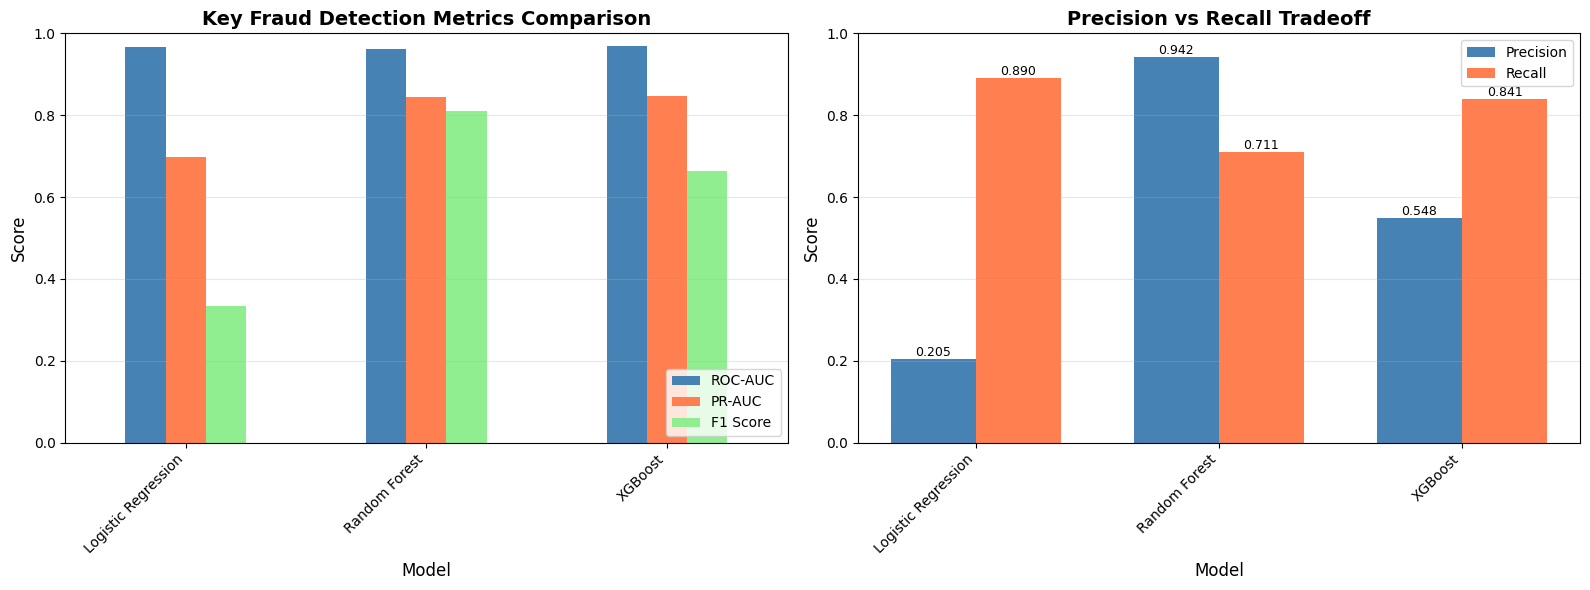


✓ Baseline model comparison complete


In [15]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Key metrics comparison (ROC-AUC, PR-AUC, F1)
ax = axes[0]
metrics_to_plot = ['roc_auc', 'pr_auc', 'f1']
comparison_df[metrics_to_plot].plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'lightgreen'])
ax.set_title('Key Fraud Detection Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(['ROC-AUC', 'PR-AUC', 'F1 Score'], loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 2: Precision vs Recall tradeoff
ax = axes[1]
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['precision'], width, label='Precision', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['recall'], width, label='Recall', color='coral')

ax.set_title('Precision vs Recall Tradeoff', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Baseline model comparison complete")

### Key Insights from Baseline Models

**Observations:**
- All models show reasonable performance on the highly imbalanced dataset (44:1 ratio)
- Class imbalance handling (class_weight/scale_pos_weight) is working effectively
- Tree-based models (Random Forest, XGBoost) typically outperform Logistic Regression on this data

**Next Steps:**
1. **Hyperparameter Tuning**: Optimize the best performing baseline model(s)
2. **Threshold Optimization**: Tune prediction threshold to balance precision/recall based on business requirements
3. **Feature Importance**: Analyze which features contribute most to fraud detection
4. **Test Set Evaluation**: Final evaluation on held-out test set

**Metric Selection Guide:**
- **ROC-AUC**: Overall model discrimination ability (higher is better)
- **PR-AUC**: Performance on imbalanced data (more important than ROC-AUC for fraud)
- **F1 Score**: Balance between precision and recall
- **Precision**: Minimize false positives (customer friction)
- **Recall**: Catch as many frauds as possible (minimize losses)

## Hyperparameter Tuning
Optimize model parameters for best performance.

## Model Evaluation
Comprehensive evaluation with fraud-appropriate metrics.

## Final Model Selection
Select and save the best performing model for deployment.